<a href="https://colab.research.google.com/github/Reinaldo0/ProjetoIA-A3/blob/main/ProjetoA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
Index: 16327 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16327 non-null  int64  
 1   Name          16327 non-null  object 
 2   Platform      16327 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16327 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16327 non-null  float64
 7   EU_Sales      16327 non-null  float64
 8   JP_Sales      16327 non-null  float64
 9   Other_Sales   16327 non-null  float64
 10  Global_Sales  16327 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
None
               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16327.000000  16327.000000  16327.000000  16327.000000  16327.000000   
mean    8292.868194   2006.406443      0.265415      0.147554      0.078661   
std     4792.669778      5.828981

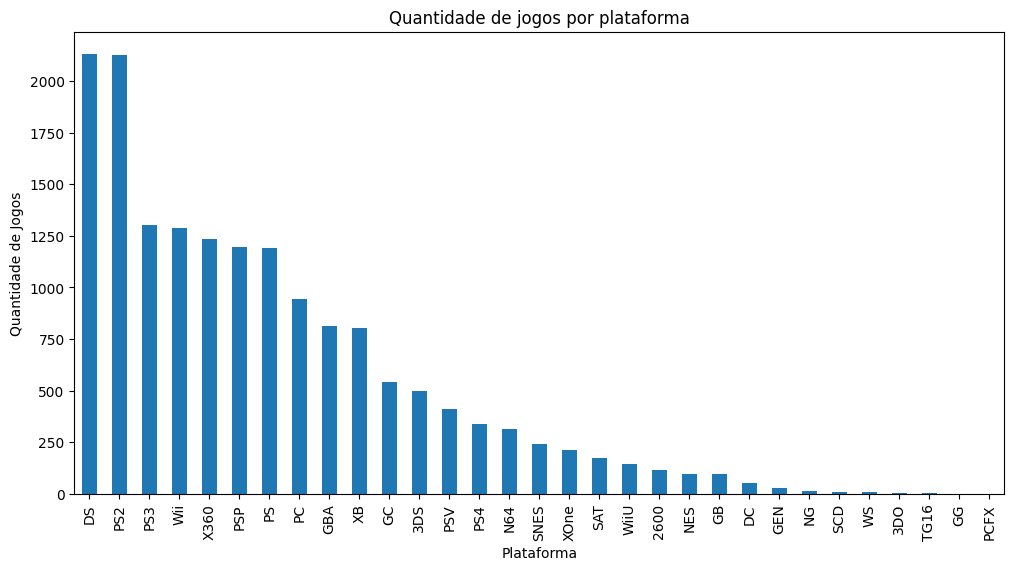

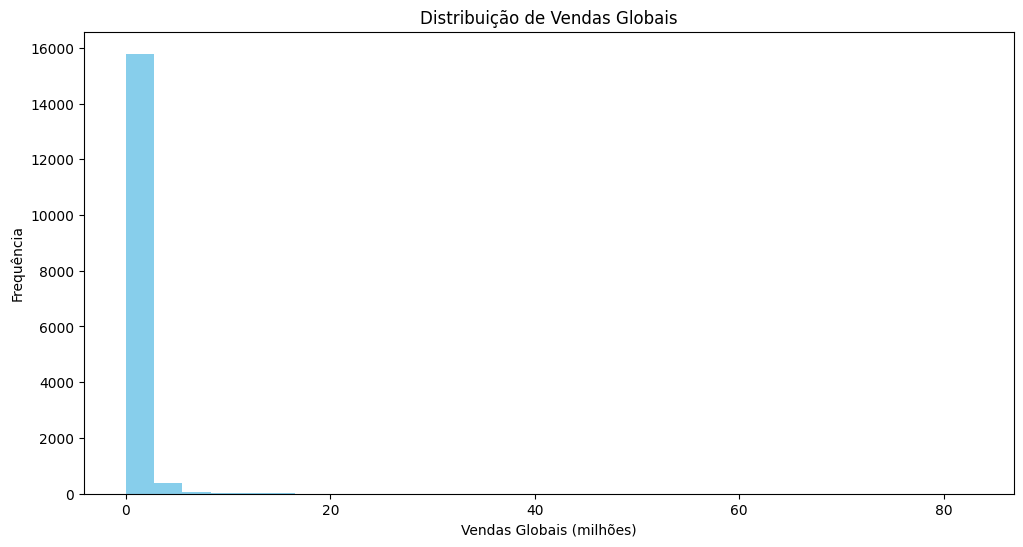


Jogos mais vendidos por plataforma:
      Platform                                    Name  Global_Sales
89        2600                                 Pac-Man          7.81
239       2600                                Pitfall!          4.50
12635      3DO                             Policenauts          0.06
14996      3DO                             Bust-A-Move          0.02
32         3DS                     Pokemon X/Pokemon Y         14.35
42         3DS                            Mario Kart 7         12.21
637         DC                         Sonic Adventure          2.42
959         DC                              Crazy Taxi          1.81
6           DS                   New Super Mario Bros.         30.01
10          DS                              Nintendogs         24.76
4           GB                Pokemon Red/Pokemon Blue         31.37
5           GB                                  Tetris         30.26
25         GBA           Pokemon Ruby/Pokemon Sapphire         15.

In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Função para carregar os dados
def carregar_dados():
    return pd.read_csv("vgsales.csv")

# Função para limpar os dados
def limpar_dados(dados):
    dados = dados.dropna(subset=['Year', 'Global_Sales'])
    dados = dados[dados['Year'].apply(lambda x: isinstance(x, (int, float)))]
    return dados

# Função para análise exploratória de dados (EDA)
def analise_exploratoria_dados(dados):
    """
    Realiza uma análise exploratória nos dados e retorna algumas visualizações.
    """
    # Verificar informações iniciais
    print(dados.info())

    # Exibir estatísticas descritivas
    print(dados.describe())

    # Distribuição por plataforma
    plt.figure(figsize=(12,6))
    dados['Platform'].value_counts().plot(kind='bar')
    plt.title("Quantidade de jogos por plataforma")
    plt.xlabel("Plataforma")
    plt.ylabel("Quantidade de Jogos")
    plt.show()

    # Distribuição de vendas
    plt.figure(figsize=(12,6))
    dados['Global_Sales'].plot(kind='hist', bins=30, color='skyblue')
    plt.title("Distribuição de Vendas Globais")
    plt.xlabel("Vendas Globais (milhões)")
    plt.ylabel("Frequência")
    plt.show()

# Função para recomendar os jogos mais vendidos por plataforma
def recomendar_jogos_mais_vendidos_geral(dados, top_n=2):
    """
    Retorna os 'top_n' jogos mais vendidos para cada plataforma,
    ordenados por plataforma.
    """
    jogos_principais = dados.sort_values(by=['Platform', 'Global_Sales'], ascending=[True, False]).groupby('Platform').head(top_n)
    return jogos_principais[['Platform', 'Name', 'Global_Sales']]

# Função para recomendar o melhor jogo de cada gênero
def recomendar_jogo_mais_vendido_por_genero(dados):
    """
    Recomenda o jogo mais vendido para cada gênero com base nas vendas globais.
    """
    jogo_mais_vendido_por_genero = dados.loc[dados.groupby('Genre')['Global_Sales'].idxmax()]
    return jogo_mais_vendido_por_genero[['Genre', 'Name', 'Global_Sales']]

# Função para realizar feature engineering
def feature_engineering(dados):
    # Adiciona novas features com base nas vendas regionais
    dados['Regional_Sales_Ratio'] = dados['Global_Sales'] / (dados['NA_Sales'] + dados['EU_Sales'] + dados['JP_Sales'] + 1e-9)
    return dados

# Função para preprocessar os dados
def preprocessar_dados(dados):
    dados = feature_engineering(dados)

    # Seleção de features
    X = dados[['Year', 'Platform', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Regional_Sales_Ratio']]
    X = pd.get_dummies(X)  # Codificação one-hot
    y = (dados['Global_Sales'] > dados['Global_Sales'].mean()).astype(int)  # Classificação binária

    # Divisão dos dados
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_treino, X_teste, y_treino, y_teste

# Função para ajustar hiperparâmetros e treinar o modelo
def ajustar_e_treinar_modelo(X_treino, y_treino):
    # Configuração dos hiperparâmetros
    parametros = {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    modelo_rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=modelo_rf, param_grid=parametros, cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_treino, y_treino)
    return grid_search.best_estimator_

# Função para avaliar o modelo
def avaliar_modelo(modelo, X_teste, y_teste):
    y_pred = modelo.predict(X_teste)
    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)

    print("\nMétricas do Modelo:")
    print(f"Acurácia: {acuracia:.2f}")
    print(f"Precisão: {precisao:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Função principal para executar o pipeline aprimorado
def main():
    # Carregar e limpar os dados
    dados = carregar_dados()
    dados = limpar_dados(dados)

    # Salva o dataset limpo em um novo arquivo CSV
    dados.to_csv("vgsales_cleaned.csv", index=False)

    # Análise exploratória de dados
    analise_exploratoria_dados(dados)

    # Recomendação de jogos mais vendidos por plataforma
    jogos_mais_vendidos_geral = recomendar_jogos_mais_vendidos_geral(dados)
    print("\nJogos mais vendidos por plataforma:")
    print(jogos_mais_vendidos_geral)

    jogos_mais_vendidos_genero = recomendar_jogo_mais_vendido_por_genero(dados)
    print("\nJogos mais vendidos por gênero:")
    print(jogos_mais_vendidos_genero)

    # Análise exploratória e feature engineering
    X_treino, X_teste, y_treino, y_teste = preprocessar_dados(dados)

    # Ajuste de hiperparâmetros e treinamento do modelo Random Forest
    modelo_rf = ajustar_e_treinar_modelo(X_treino, y_treino)

    # Avaliação do modelo Random Forest
    print("\nResultados do modelo Random Forest aprimorado:")
    avaliar_modelo(modelo_rf, X_teste, y_teste)

# Executa o pipeline
main()
